In [1]:
import json

import matplotlib.pyplot as plt
import nibabel as nii
import numpy as np
from pathlib import Path
from skimage import color
from tqdm import tqdm

In [31]:
def read_image(path: Path) -> np.array:
    image = nii.load(path).get_fdata()
    image = (image - image.min()) / (image.max() - image.min() + 1e-8) * 255
    image = image.astype(np.uint8)
    assert len(image.shape) == 3, image.shape[:2] == (512, 512)
    return image


def read_label(path: Path):
    label = nii.load(path).get_fdata()
    assert np.all((label == 0.) | (label == 1.)), f"Inconsistent data: labels contains: {np.unique(label)}"
    assert len(label.shape) == 3, label.shape[:2] == (512, 512)
    label = label.astype(np.uint8)
    return label


In [32]:
def preprocess_data(raw_data: Path, save_dir: Path, train: bool = True):
    prefix = "training" if train else "testing"
    print(f"Preprocessing {prefix}...")

    training_json = json.load(open(raw_data / f"{prefix}_data.json"))

    images, labels, frame_names = [], [], []
    for entry in tqdm(training_json, desc=f"Processing {prefix} images/labels"):
        image_path = raw_data / "images" / entry['image'][:-3]
        image = read_image(image_path)
        images.append(image)

        name = image_path.name
        num_images = image.shape[2]
        frame_names.extend([f"{name}_{ii}" for ii in range(num_images)])

        if train:
            label_path = raw_data / "labels" / entry['label'][:-3]
            label = read_label(label_path)
            labels.append(label)


    images = np.concatenate(images, axis=2, dtype=np.uint8)
    images = np.transpose(images, axes=(2, 0, 1))
    print(f"Images shape: {images.shape}")

    if train:
        labels = np.concatenate(labels, axis=2, dtype=np.uint8)
        labels = np.transpose(labels, axes=(2, 0, 1))
        print(f"Labels shape: {labels.shape}")

    np.save(str(save_dir / f"{prefix}_images.npy"), images)

    if train:
        np.save(str(save_dir / f"{prefix}_labels.npy"), labels)

    (save_dir / f"{prefix}_frame_names.txt").write_text(" ".join(frame_names))

    print(f"{prefix} completed!")


preprocess_data(
    raw_data=Path("../data/raw"),
    save_dir=Path("../data/preprocessed"),
    train=True
)

preprocess_data(
    raw_data=Path("../data/raw"),
    save_dir=Path("../data/preprocessed"),
    train=False
)

Preprocessing training...


Processing training images/labels: 100%|██████████| 40/40 [00:04<00:00,  8.08it/s]


Images shape: (1651, 512, 512)
Labels shape: (1651, 512, 512)
training completed!
Preprocessing testing...


Processing testing images/labels: 100%|██████████| 10/10 [00:00<00:00, 13.82it/s]


Images shape: (398, 512, 512)
testing completed!


In [4]:
training_images = np.load("../data/preprocessed/training_images.npy")
training_labels = np.load("../data/preprocessed/training_labels.npy")

684
559
1216
835
763


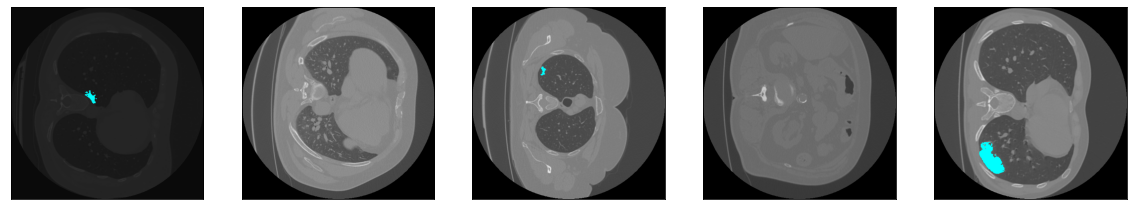

In [38]:
def visualize_prediction(segmentation, label):
    blue_color = (0, 255, 255)
    segmentation = color.gray2rgb(segmentation)
    segmentation[label == 1] = blue_color
    return segmentation

def visualize_samples(images, labels, label: str, n_images=5):
    fig, axes = plt.subplots(ncols=n_images, figsize=(20, 4))
    np.random.seed(0)
    for ii, item in enumerate(np.random.randint(0, len(images), size=n_images)):
        print(item)
        visualization = visualize_prediction(images[item], labels[item])
        axes[ii].imshow(visualization)
        axes[ii].set_xticks([])
        axes[ii].set_yticks([])


    plt.show()

visualize_samples(training_images, training_labels, label="Training images")